In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("assessment.csv")
df.head()

user_id  Channel  TotalTransactionAmount  Tx_Count  DaysSinceLastTrans  \
0     1191      8.0                  532700       137                  30   
1     1287      1.0                 1635552       131                  30   
2     1168      8.0                  548300       114                  30   
3     1119      2.0                   12200        13                  30   
4     1168      8.0                  211700        75                  30   

   reseller_id  superdealer_id Product_ServiceProvider Product_Type  \
0       1130.0            18.0            Jos Electric     Postpaid   
1          0.0            18.0                     MTN      Airtime   
2       1130.0            18.0            Jos Electric     Postpaid   
3          0.0           447.0                  Airtel         Data   
4       1130.0            18.0            Jos Electric      Prepaid   

  Product_Category  
0      Electricity  
1            Telco  
2      Electricity  
3            Telco  
4      Electricity

In [3]:
df.shape

(2635, 10)

In [4]:
# Do we have missing values?
df.isnull().sum().sort_values(ascending=False).head()  

Product_ServiceProvider    179
Product_Type               179
Product_Category           179
Channel                      2
reseller_id                  2
dtype: int64

In [5]:
# Imputing missing values with mean
df.loc[(df['Channel'].isnull() == True), 'Channel'] = df['Channel'].mean()
df.loc[(df['reseller_id'].isnull() == True), 'reseller_id'] = df['reseller_id'].mean()
df.loc[(df['superdealer_id'].isnull() == True), 'superdealer_id'] = df['superdealer_id'].mean()

In [6]:
df.isnull().sum().sort_values(ascending=False).head()

Product_ServiceProvider    179
Product_Type               179
Product_Category           179
user_id                      0
Channel                      0
dtype: int64

In [7]:
df["Product_ServiceProvider"].fillna("missing", inplace = True)
df["Product_Type"].fillna("missing", inplace = True)
df["Product_Category"].fillna("missing", inplace = True)

In [8]:
df.isnull().sum().sort_values(ascending=False).head()

user_id                   0
Channel                   0
TotalTransactionAmount    0
Tx_Count                  0
DaysSinceLastTrans        0
dtype: int64

In [35]:
df['reseller_id'].value_counts() 

0.000000       2392
1130.000000     151
1802.000000      30
553.000000       19
2557.000000      15
56.000000        11
464.000000        9
910.000000        3
2379.000000       2
108.876946        2
841.000000        1
Name: reseller_id, dtype: int64

In [36]:
df['Channel'].value_counts() 

1.000000     1890
2.000000      526
8.000000      102
10.000000      42
5.000000       33
6.000000       28
4.000000        6
3.000000        5
1.730725        2
7.000000        1
Name: Channel, dtype: int64

In [9]:
df['Product_ServiceProvider'].value_counts() 

MTN                      813
Airtel                   700
Glo                      422
9mobile                  355
missing                  179
Jamb                      42
Eko Electric              33
Jos Electric              32
Ikeja Electric            18
DSTV                      13
Ibadan Electric           13
GOTV                      10
Portharcourt Electric      3
Startimes                  2
Name: Product_ServiceProvider, dtype: int64

In [10]:
df['Product_Type'].value_counts() 

Airtime        1878
Data            398
missing         179
Prepaid          71
E-facility       42
Postpaid         28
Pay TV           25
Voucher Pin      14
Name: Product_Type, dtype: int64

In [11]:
df['Product_Category'].value_counts() 

Telco            2276
missing           179
Electricity        99
Education          42
Cable TV           25
Universal Pin      14
Name: Product_Category, dtype: int64

In [12]:
df.describe()

user_id      Channel  TotalTransactionAmount      Tx_Count  \
count  2635.000000  2635.000000            2.635000e+03   2635.000000   
mean   1251.568880     1.730725            5.815019e+04     91.971157   
std     664.557929     1.833842            5.766734e+05   1223.775908   
min       3.000000     1.000000            1.000000e+00      1.000000   
25%     816.000000     1.000000            2.000000e+02      1.000000   
50%    1140.000000     1.000000            1.000000e+03      3.000000   
75%    1613.500000     2.000000            4.952000e+03      9.000000   
max    2725.000000    10.000000            2.086921e+07  46531.000000   

       DaysSinceLastTrans  reseller_id  superdealer_id  
count         2635.000000  2635.000000     2635.000000  
mean           119.154459   108.876946      389.900494  
std             84.336623   379.516871      271.450186  
min             30.000000     0.000000        0.000000  
25%             54.000000     0.000000      447.000000  
50%            107.000000     0.000000      447.000000  
75%            147.000000     0.000000      447.000000  
max            735.000000  2557.000000     2494.000000

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2635 entries, 0 to 2634
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  2635 non-null   int64  
 1   Channel                  2635 non-null   float64
 2   TotalTransactionAmount   2635 non-null   int64  
 3   Tx_Count                 2635 non-null   int64  
 4   DaysSinceLastTrans       2635 non-null   int64  
 5   reseller_id              2635 non-null   float64
 6   superdealer_id           2635 non-null   float64
 7   Product_ServiceProvider  2635 non-null   object 
 8   Product_Type             2635 non-null   object 
 9   Product_Category         2635 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 206.0+ KB


In [14]:
df = df.drop(columns=['user_id', 'Tx_Count','DaysSinceLastTrans'])

In [15]:
df_filled = df.copy()

In [16]:
# Turn categorical variables into numbers
for label, content in df_filled.items():
    if not pd.api.types.is_numeric_dtype(content):
        # We add the +1 because pandas encodes missing categories as -1
        df_filled[label] = pd.Categorical(content).codes+1

In [17]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2635 entries, 0 to 2634
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Channel                  2635 non-null   float64
 1   TotalTransactionAmount   2635 non-null   int64  
 2   reseller_id              2635 non-null   float64
 3   superdealer_id           2635 non-null   float64
 4   Product_ServiceProvider  2635 non-null   int8   
 5   Product_Type             2635 non-null   int8   
 6   Product_Category         2635 non-null   int8   
dtypes: float64(3), int64(1), int8(3)
memory usage: 90.2 KB


In [18]:
# Standardization
for i in df_filled.select_dtypes(exclude='object').columns:
    df_filled.loc[:, i] = StandardScaler().fit_transform(np.array(df_filled[[i]]))

In [23]:
from kmodes.kprototypes import KPrototypes

# Choosing optimal K
cost = []
for k in range(1,10):
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    kproto.fit_predict(df_filled, categorical=[1,2])
    cost.append(kproto.cost_);

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


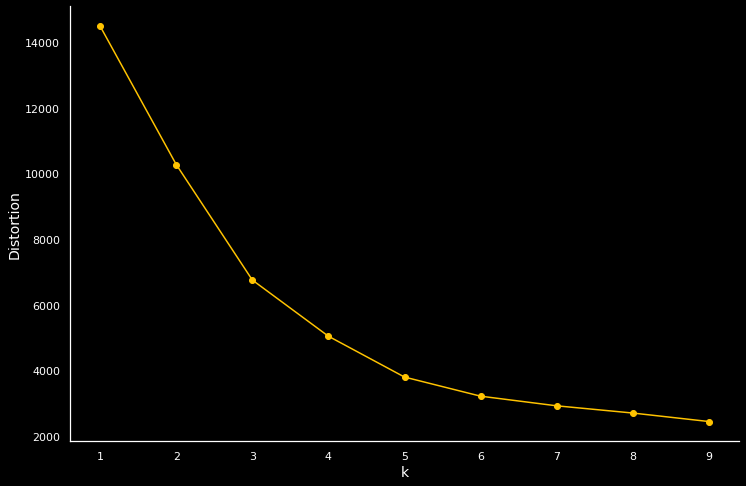

In [24]:
fig, ax = plt.subplots(figsize =(12, 8))

plt.plot(range(1,10), cost, 'bo-', color = '#FFC300')
plt.xlabel('k', color = 'white', size = 14)
plt.ylabel('Distortion', color = 'white', size = 14)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

We use the *Elbow Method* to determine the optimal number of clusters to use. In our case, we'll choose **4 clusters**.

In [25]:
# Clustering
kproto = KPrototypes(n_clusters= 4, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(df_filled, categorical=[1,2])

In [26]:
# Merging original data with clusters
df_clusters = pd.concat([df, pd.DataFrame({'cluster': clusters})], axis=1) 

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


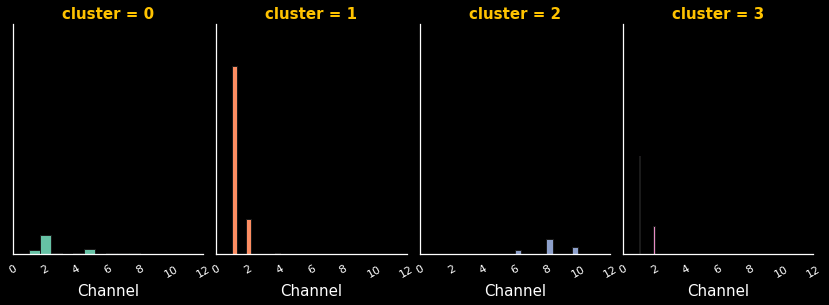

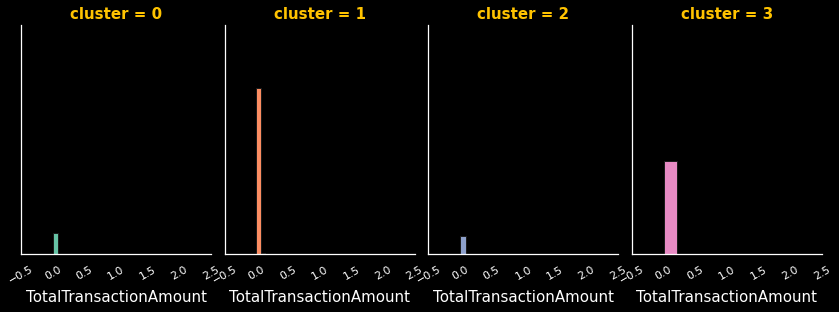

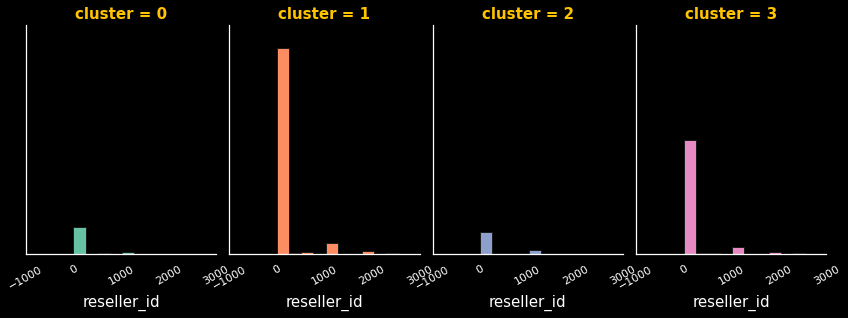

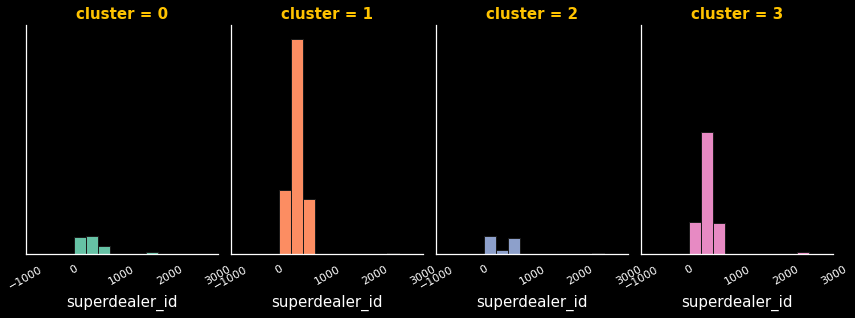

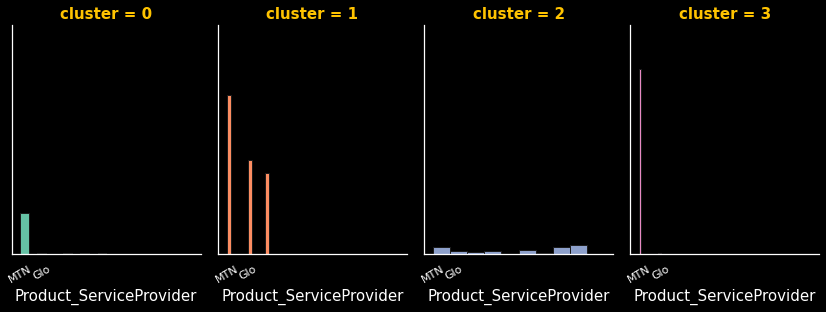

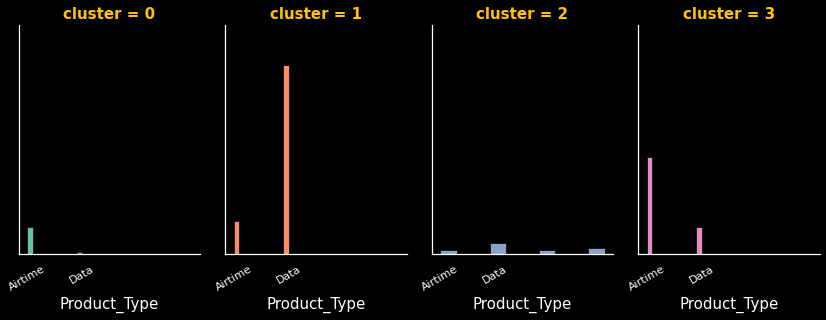

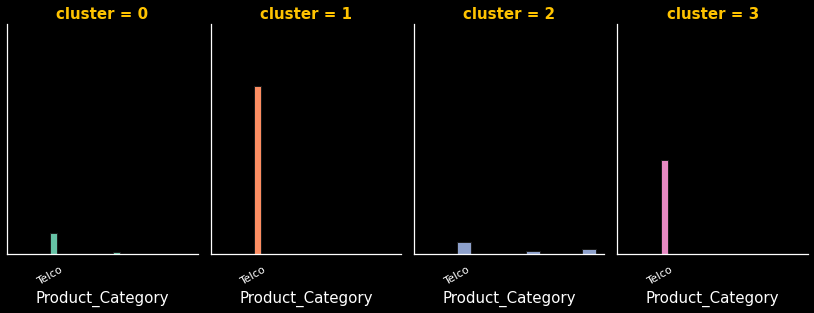

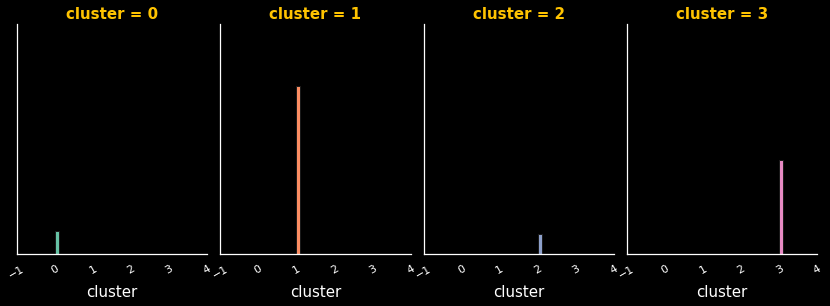

In [28]:
# Clusters interpretation
for i in df_clusters:
    g = sns.FacetGrid(df_clusters, col = "cluster", hue = "cluster", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=30, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)

* **Cluster 0**: Customers with low activity within the same region that tends to purchase airtime only. We will call this group *good customers*.
* **Cluster 1**: Very active customers, who purchase more of data from a particular reseller. We will call this group *elite customers*.
* **Cluster 2**: Customers that makes you of all the product types *cheap customers*.
* **Cluster 3**: Good customer groups that purchases more of Airtime than data. We will call this group *economical customers*.

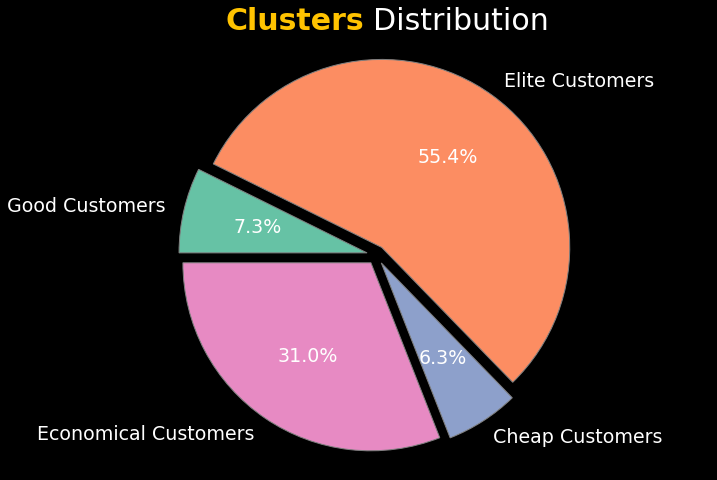

In [34]:
# Results
clusters_count = df_clusters['cluster'].value_counts()                        # Counting wins-losses-draws
clusters_count = clusters_count.to_frame().reset_index()                      # Convert series to dataframe
clusters_count.columns = ['clusters', 'count']                                # Rename column names
clusters_count = clusters_count.sort_values('clusters', ascending = True)     # Sorting data

labels = [
        "Good Customers", 
        "Elite Customers", 
        "Cheap Customers",
        "Economical Customers"
        ]

# Visualization
plt.figure(figsize=(12,8))

plt.rcParams['font.size'] = 17
colors = sns.color_palette('Set2')[0:4]

plt.pie(clusters_count['count'], 
        explode=(0.05, 0.05, 0.05, 0.05), 
        labels = labels,
        colors= colors,
        autopct='%1.1f%%',
        textprops = dict(color ="white", fontsize=19),
        counterclock = False,
        startangle=180,
        wedgeprops={"edgecolor":"gray",'linewidth': 1}
        )

plt.axis('equal')

# Title 
plt.text(-0.8, 1.2, "Clusters", size=30, color="#FFC300", fontweight="bold")
plt.text(-0.12, 1.2, "  Distribution", size=30, color="white")

plt.show()


# Conclusion

To conclude this project, we'll offer some recommendations for the company based on our analysis:

1. Airtime and data are the most popular products amongst all the groups. It would be beneficial to offer a greater variety of these products or special deals in these categories.

2. Most customers are buying from a single reseller or superdealer, we need to figure out what's going on with the rest and how to increase their sales.

3. On the other hand, there are  certain group of consumers that don't spend much on their products. For this group, they could offer a section with very affordable and cheap products.